In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import GetGHZCircuitsForModel
from circuits.modify_circuits import append_pqc_to_quantum_circuit
from circuits.pqc_circuits import pennylane_PQC_RZRXRZ_unique, qiskit_PQC_RZRXRZ_unique

from simulator.simulate import get_ideal_data_superpos

from models.pennylane_models import SimplePennylaneQuantumStateModel
from models.noise_models import BitPhaseFlipNoise

from utils.loss_functions import QuantumFidelityLoss 

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 2
INPUT_BITS = '10101'
EPOCHS = 5
# fakeVigo2_backend = FakeVigoV2()
# fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
# noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)
pqc_arch = pennylane_PQC_RZRXRZ_unique

In [6]:
# class SimplePennylaneQuantumStateModel(nn.Module):
#     def __init__(self, num_qubits, num_params, pqc_arch_func, 
#                  qdevice="default.qubit"):
        
#         super(SimplePennylaneQuantumStateModel, self).__init__()

#         self.num_qubits = num_qubits
#         self.raw_params = nn.Parameter(torch.randn(num_params) * 2 * torch.pi)
#         self.pqc_arch = pqc_arch_func
        
#         self.qml_device = qml.device(qdevice, wires=num_qubits)

#         @qml.qnode(self.qml_device, interface='torch', diff_method='backprop')
#         def circuit_sim(param_tensor, circuit_unitary:Operator):
#             # ⬇ Base circuit (e.g., noisy GHZ, etc.)
#             qml.QubitUnitary(circuit_unitary, wires=range(self.num_qubits))  # fixed input/inverse

#             # ⬇ Append parameterized PQC (θ = π·sin(x))
#             # bounded_params = torch.pi * torch.sin(param_tensor)
#             pqc_arch_func(num_qubits, param_tensor)

#             # ⬇ Measurement: return probabilities (or expectation values)
#             return qml.state()

#         self.qnode = circuit_sim
    
#     def forward(self, circuit=QuantumCircuit):
#         circuit_op = Operator(circuit)
#         return self.qnode(self.raw_params, circuit_op.data)

In [7]:
# class QuantumFidelityLoss(nn.Module):
#     def __init__(self, is_statevector=True, num_shots=1024, eps: float = 1e-8):
#         """
#         @param is_statevector: If True, expects ideal and measured to be complex statevectors.
#                                If False, treats them as shot counts or probability distributions.
#         @param num_shots: Used only when input is shot counts.
#         """
#         super(QuantumFidelityLoss, self).__init__()
#         self.is_statevector = is_statevector
#         self.num_counts = num_shots
#         self.eps = eps

#     def forward(self, ideal: torch.Tensor, measured: torch.Tensor) -> torch.Tensor:
#         if self.is_statevector:
#             # Ensure inputs are complex tensors
#             if not torch.is_complex(ideal):
#                 raise ValueError("Ideal input must be a complex-valued statevector")
#             if not torch.is_complex(measured):
#                 raise ValueError("Measured input must be a complex-valued statevector")

#             # Normalize just in case
#             psi = ideal / torch.linalg.norm(ideal)
#             phi = measured / torch.linalg.norm(measured)

#             overlap = torch.dot(torch.conj(psi), phi)
#             fidelity = torch.abs(overlap) ** 2
#             return 1.0 - torch.real(fidelity)

#         else:
#             # Classical fidelity loss using counts or probs
#             p = ideal / self.num_counts + self.eps
#             q = measured / self.num_counts + self.eps
#             p = p / p.sum()
#             q = q / q.sum()

#             fidelity = torch.square(torch.sum(torch.sqrt(p * q)))
#             return 1.0 - fidelity

In [8]:
noise_model = BitPhaseFlipNoise()

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
    )

pqc_model = SimplePennylaneQuantumStateModel(
    num_qubits= NUM_QUBITS, num_params=NUM_QUBITS*3, pqc_arch_func=pqc_arch
    )


In [9]:
ideal_data = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=int(1000), statevector=True)
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))
print(ideal_data[10][1].dtype)


Generating Ideal Data: 100%|██████████| 1000/1000 [00:00<00:00, 2259.24it/s]

32
torch.complex128


In [10]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.005)
loss_fn = QuantumFidelityLoss(is_statevector=True)
# loss_fn = nn.MSELoss()

In [11]:
param_list_epoch = []  # Stores parameter evolution across epochs
loss_list_epoch = []   # Stores mean loss per epoch

enable_debug_logs = True  # Set False to suppress grad/param printouts
lambda_reg = 0.01         # Regularization weight

for epoch in range(EPOCHS):
    print(f'\n Starting Epoch {epoch+1}')
    pqc_model.train()
    epoch_loss_list = []
    epoch_param_snapshots = []

    shuffle(ideal_data)
    data_iterator = tqdm(ideal_data)

    for step, (params, ideal) in enumerate(data_iterator):
        optimizer.zero_grad()

        circuit = ghz_circuit_gen.get_noisy_model_circuit_params(params)
        measured = pqc_model(circuit=circuit)

        ideal = ideal.to(torch_device)
        measured = measured.to(torch_device)

        # print(ideal)
        # print(measured)

        # Compute fidelity loss
        loss = loss_fn(ideal, measured)

        # Add optional regularization to keep angles from zeroing out

        loss.backward()
        optimizer.step()

        raw_param_values = pqc_model.raw_params.detach().cpu().numpy()
        epoch_param_snapshots.append(raw_param_values)
        epoch_loss_list.append(loss.item())

        data_iterator.set_postfix_str(f"Loss: {loss.item():.4e}")

        # Optional: print debug stats
        if enable_debug_logs and step == 0:
            grad_norm = pqc_model.raw_params.grad.norm().item()
            # bounded = pqc_model.raw_params.detach().cpu().numpy()
            print(f"\tStep {step}, grad norm: {grad_norm:.4e}")
            print(f"\tRaw param range: [{raw_param_values.min():.3f}, {raw_param_values.max():.3f}]")
            # print(f"\tBounded param range: [{bounded.min():.3f}, {bounded.max():.3f}]")

    # Log epoch summary
    avg_loss = np.mean(epoch_loss_list)
    loss_list_epoch.append(avg_loss)
    param_list_epoch.extend(np.array(epoch_param_snapshots))

    print(f"Epoch {epoch+1} complete: avg loss = {avg_loss:.4e}")

    


 Starting Epoch 1


  1%|          | 11/1000 [00:00<00:27, 35.48it/s, Loss: 9.7621e-01]

	Step 0, grad norm: 3.5131e-02
	Raw param range: [-9.186, 12.162]


100%|██████████| 1000/1000 [00:14<00:00, 66.72it/s, Loss: 7.3782e-02]


Epoch 1 complete: avg loss = 3.2916e-01

 Starting Epoch 2


  0%|          | 5/1000 [00:00<00:22, 45.15it/s, Loss: 2.6875e-02]

	Step 0, grad norm: 2.1230e-01
	Raw param range: [-8.977, 11.511]


100%|██████████| 1000/1000 [00:19<00:00, 52.13it/s, Loss: 4.6470e-02]


Epoch 2 complete: avg loss = 4.7376e-02

 Starting Epoch 3


  1%|          | 9/1000 [00:00<00:11, 87.41it/s, Loss: 2.4064e-02]

	Step 0, grad norm: 1.2182e-01
	Raw param range: [-9.138, 11.484]


100%|██████████| 1000/1000 [00:14<00:00, 68.12it/s, Loss: 6.2074e-02]


Epoch 3 complete: avg loss = 4.4379e-02

 Starting Epoch 4


  1%|          | 10/1000 [00:00<00:11, 89.40it/s, Loss: 2.8181e-02]

	Step 0, grad norm: 9.3016e-02
	Raw param range: [-9.268, 11.491]


100%|██████████| 1000/1000 [00:18<00:00, 54.56it/s, Loss: 1.5020e-02]


Epoch 4 complete: avg loss = 4.3512e-02

 Starting Epoch 5


  1%|          | 6/1000 [00:00<00:17, 56.19it/s, Loss: 3.3859e-02]

	Step 0, grad norm: 4.7726e-02
	Raw param range: [-9.312, 11.528]


100%|██████████| 1000/1000 [00:18<00:00, 54.45it/s, Loss: 2.9403e-02]

Epoch 5 complete: avg loss = 4.3230e-02


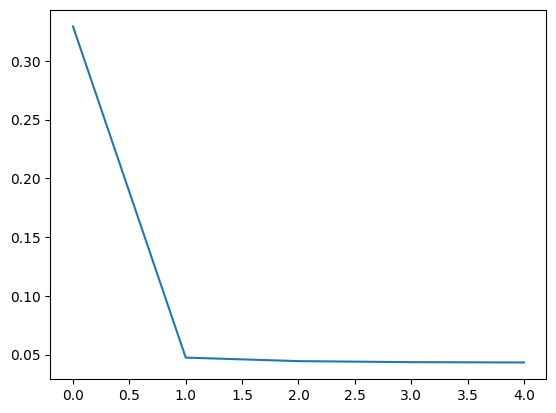

In [12]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [13]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
# noisy_model_circ.draw('mpl')
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, qiskit_PQC_RZRXRZ_unique)
# noisy_model_circ_pqc.draw('mpl')

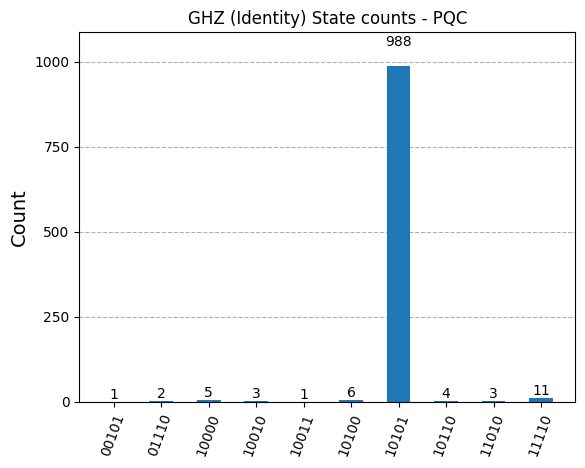

In [14]:
transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

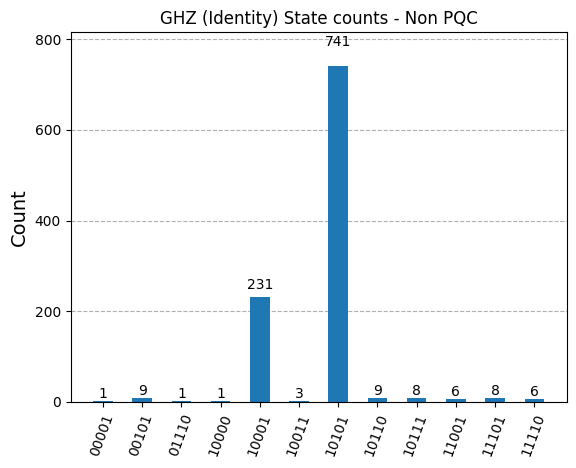

In [15]:
transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')

In [16]:
from simulator.simulate import run_circuit_sampler

def counts_to_probs(counts: torch.Tensor) -> torch.Tensor:
    """Convert integer counts to a normalized probability vector."""
    return counts.float() / counts.sum()

def fidelity(p, q):
    return torch.square(torch.sqrt(p * q).sum())

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.raw_params

ideal_data_test = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=20)

for param, ideal in ideal_data_test:
    noisy_circ = ghz_circuit_gen.get_noisy_model_circuit_params(params=param)
    noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, qiskit_PQC_RZRXRZ_unique)

    counts_noisy = run_circuit_sampler(noisy_circ.measure_all(inplace=False))
    counts_noisy_pqc = run_circuit_sampler(noisy_circ_pqc)

    prob_i = counts_to_probs(ideal)
    prob_n = counts_to_probs(counts_noisy)
    prob_ne = counts_to_probs(counts_noisy_pqc)

    fid_i_n = fidelity(prob_i, prob_n)
    fid_i_ne = fidelity(prob_i, prob_ne)

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

    

Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 457.63it/s]


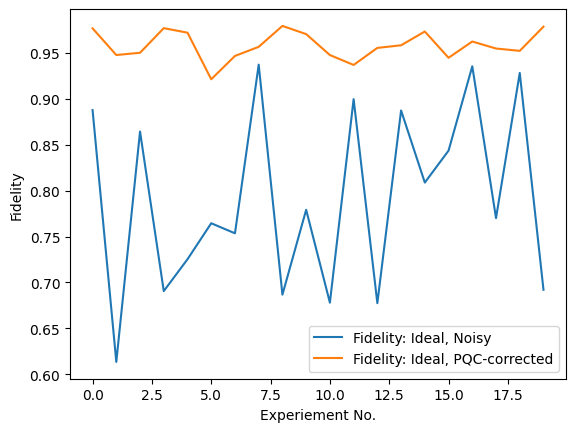

In [17]:
x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

In [18]:
print(f"Avg Fidelity of noisy circuit: {np.mean(fid_noisy)}, Average Fidelity of noisy circ with PQC: {np.mean(fid_noisy_pqc)}")

Avg Fidelity of noisy circuit: 0.7911967635154724, Average Fidelity of noisy circ with PQC: 0.9582598805427551
